In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from display_xml import XML
import CLB.CLBXMLWriter as CLBXML   

Hello allocator!
Hello allocator!
Hello allocator!


<Figure size 432x288 with 0 Axes>

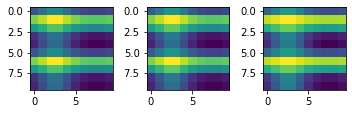

Hello allocator!
Hello allocator!
Hello allocator!


<Figure size 432x288 with 0 Axes>

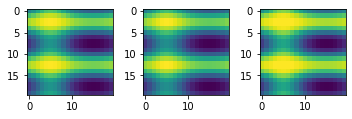

Hello allocator!
Hello allocator!
Hello allocator!


<Figure size 432x288 with 0 Axes>

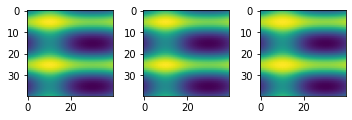

Hello allocator!
Hello allocator!
Hello allocator!


<Figure size 432x288 with 0 Axes>

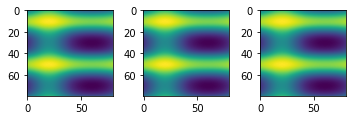

Hello allocator!
Hello allocator!
Hello allocator!


<Figure size 432x288 with 0 Axes>

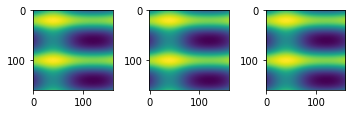

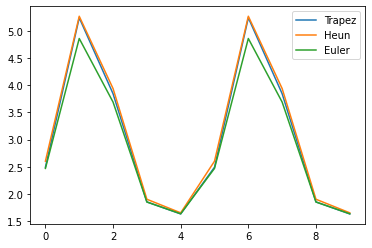

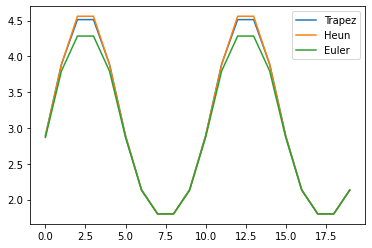

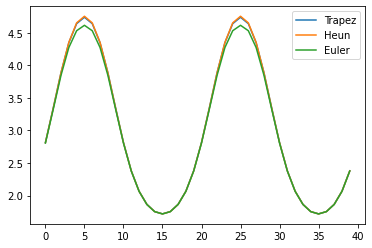

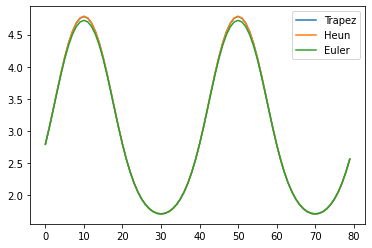

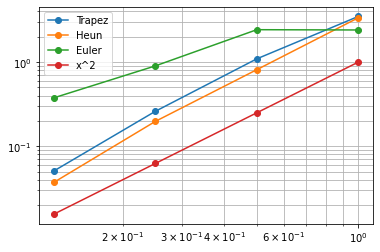

In [10]:
shapes_trapez = list()
shapes_heun = list()
shapes_euler = list()

factors = [1,2,4,8,16]
spatial = True

for factor in factors:
    if spatial:
        time_factor = factor#**2
        space_factor = factor
    else:
        time_factor = factor
        space_factor = 1
    
    
    
    domain_size = 10 * space_factor
    time = 1 * time_factor

    CLBc = CLBXML.CLBConfigWriter( )

    CLBc.addGeomParam('nx', domain_size)
    CLBc.addGeomParam('ny', domain_size)

    CLBc.addCollisionBlock(name='TRT_M')
    CLBc.addBox()

    params = {
            "Diffusivity_PHI":0.001 * time_factor / space_factor**2,
            "Init_PHI":0.1,
            "Lambda": 0.01 / time_factor
    }

    CLBc.addModelParams(params)

    
    if spatial: CLBc.addRunR(eval=\
        """
                x = Solver$Geometry$X 
                x = (x - 0.5)/ ({domain_size}) * 2 * pi
                y = Solver$Geometry$Y
                y = (y - 0.5)/ ({domain_size}) * 2 * pi
                Solver$Fields$Init_PHI_External[] = exp(sin(x)) + 2*exp(sin(2*y)) # to benchmark diffusion & source term
                Solver$Actions$InitFromExternalAction()        
        """.format(domain_size=domain_size))

    CLBc.addHDF5()
    solve = CLBc.addSolve(iterations=time)
    #CLBc.addHDF5(Iterations=time/10, parent=solve)
    CLBc.addHDF5()

    CLBc.write('AllenCahnTrapezoidal.xml')

    #f = open('AllenCahnTrapezoidal.xml', 'r')
    #XML(''.join(f.readlines()))

    ! rm -rf ./output/AllenCahnTrapezoidal* && tclb d2q9_reaction_diffusion_system_AllenCahn AllenCahnTrapezoidal.xml > /dev/null

    TimeSteps2 = list()
    plt.figure()
    fig, axs = plt.subplots(1,3,figsize=(5,5))
    # fig, axs = plt.subplots(1,2,figsize=(5,5))
    # for ax,i in zip(axs.ravel(), range(0,time,int(time/10))[:2]):
    #     f = h5py.File('./output/AllenCahnTrapezoidal_HDF5_%08d.h5'%i)    
    #     figid = figid + 1
    #     ax.imshow(f['PHI'][0,:,:])
    #     ax.set_title(i)
    # plt.tight_layout()
    ax = axs[0]
    f = h5py.File('./output/AllenCahnTrapezoidal_HDF5_%08d.h5'%time)    
    ax.imshow(f['PHI'][0,:,:])

    shapes_trapez.append(f['PHI'][0,:,:])
    
 
    ! rm -rf ./output/AllenCahnTrapezoidal* && tclb d2q9_reaction_diffusion_system_AllenCahn_Heun AllenCahnTrapezoidal.xml > /dev/null

    # TimeSteps2 = list()
    # plt.figure()
    # fig, axs = plt.subplots(1,2,figsize=(5,5))
    # for ax,i in zip(axs.ravel(), range(0,time,int(time/10))[:2]):
    #     f = h5py.File('./output/AllenCahnTrapezoidal_HDF5_%08d.h5'%i)    
    #     figid = figid + 1
    #     ax.imshow(f['PHI'][0,:,:])
    #     ax.set_title(i)
    # plt.tight_layout()
    ax = axs[1]
    f = h5py.File('./output/AllenCahnTrapezoidal_HDF5_%08d.h5'%time)    
    ax.imshow(f['PHI'][0,:,:])
    
    shapes_heun.append(f['PHI'][0,:,:])

    ! rm -rf ./output/AllenCahnTrapezoidal* && tclb d2q9_reaction_diffusion_system_AllenCahn_Euler AllenCahnTrapezoidal.xml > /dev/null

    # TimeSteps2 = list()
    # plt.figure()
    # fig, axs = plt.subplots(1,2,figsize=(5,5))
    # for ax,i in zip(axs.ravel(), range(0,time,int(time/10))[:2]):
    #     f = h5py.File('./output/AllenCahnTrapezoidal_HDF5_%08d.h5'%i)    
    #     figid = figid + 1
    #     ax.imshow(f['PHI'][0,:,:])
    #     ax.set_title(i)
    # plt.tight_layout()
    ax = axs[2]
    f = h5py.File('./output/AllenCahnTrapezoidal_HDF5_%08d.h5'%time)    
    ax.imshow(f['PHI'][0,:,:])
    
    shapes_euler.append(f['PHI'][0,:,:])
    plt.tight_layout()
    plt.show()
    
    
l2_trapez = list()
l2_heun = list()
l2_euler = list()

for n, shape_trapez, shape_heun, shape_euler in zip(factors[:-1], shapes_trapez[:-1], shapes_heun[:-1], shapes_euler[:-1]):
    plt.figure()
    plt.plot(shape_trapez[:,0], label='Trapez')   
    plt.plot(shape_heun[:,0], label='Heun')   
    plt.plot(shape_euler[:,0], label='Euler')   
    plt.legend()
    #plt.plot(shapes_trapez[-1][:,0])
    
    l2_trapez.append(np.sqrt( np.sum((shape_trapez[::n,::n] - shapes_trapez[-1][::factors[-1],::factors[-1]])**2 )))
    l2_heun.append(np.sqrt( np.sum((shape_heun[::n,::n] - shapes_trapez[-1][::factors[-1],::factors[-1]])**2 )))
    l2_euler.append(np.sqrt( np.sum((shape_euler[::n,::n] - shapes_trapez[-1][::factors[-1],::factors[-1]])**2 )))

plt.figure()
plt.loglog(1/np.array(factors[:-1]), l2_trapez, 'o-', label='Trapez')    
plt.loglog(1/np.array(factors[:-1]), l2_heun, 'o-', label='Heun')    
plt.loglog(1/np.array(factors[:-1]), l2_euler, 'o-', label='Euler')


plt.loglog(1/np.array(factors[:-1]), 1/np.array(factors[:-1])**2, 'o-', label='x^2')   

plt.legend()
plt.grid(which='both')

In [11]:
np.log10(l2_trapez[0]/l2_trapez[-2]) / np.log10(4)

1.872109479508962

In [12]:
np.log10(l2_euler[0]/l2_euler[-2]) / np.log10(4)


0.708794426500638

In [13]:
np.log10(l2_heun[1]/l2_heun[-1]) / np.log10(4)


2.2235887008714394